In [1]:
import os
import pandas as pd
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
zip_path = tf.keras.utils.get_file(
  origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
  fname='jena_climate_2009_2016.csv.zip',
  extract=True)

csv_path, _ = os.path.splitext(zip_path)

13582336/13568290 [==============================] - 0s 0us/step


In [21]:
df = pd.read_csv(csv_path)

In [22]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
df.info()

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
import csv
def parse_data_from_file(filename):    
    times = []
    pression = []

    with open(filename) as csvfile:
        i=0
        reader = csv.reader(csvfile, delimiter=",")
        next(reader)
        for row in reader:
            pression.append(float(row[2]))
            times.append(i)
            i+=1
    return times, pression

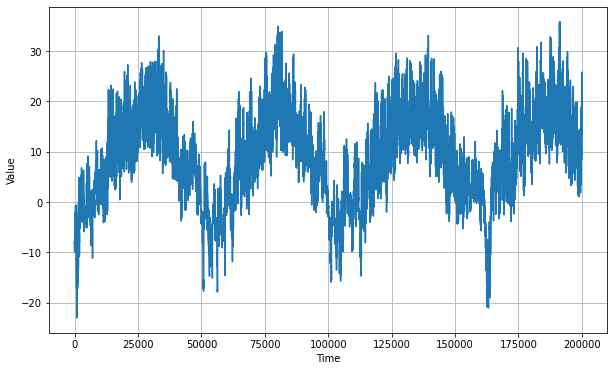

In [6]:
@dataclass
class G:
    times, pression = parse_data_from_file(csv_path)
    TIME = times[:200000]
    SERIES = pression[:200000]
    SPLIT_TIME = 160000
    WINDOW_SIZE = 160
    BATCH_SIZE = 320
    SHUFFLE_BUFFER_SIZE = 2000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [7]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
    return time_train, series_train, time_valid, series_valid

# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [8]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [9]:
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis=-1), input_shape=[G.WINDOW_SIZE]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x:x*100)     
    ]) 
    return model

In [33]:
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Your current architecture is compatible with the windowed dataset! :)


In [34]:
def adjust_learning_rate(dataset):   
    model = create_uncompiled_model()   
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 

    history = model.fit(dataset, epochs=50, callbacks=[lr_schedule])
    
    return history

In [ ]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

In [ ]:
#Plot learning rates
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 1e-2, 0, 100])

In [10]:
def create_model():   
    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1.4e-04, momentum=0.9),
                  metrics=["mse","mae"])  
    return model

In [ ]:
model = create_model()

# Train it
history = model.fit(train_set, epochs=30)

In [12]:
def compute_metrics(true_series, forecast):    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    return mse, mae

In [13]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(1000).prefetch(1)
    forecast = model.predict(ds)
    return forecast

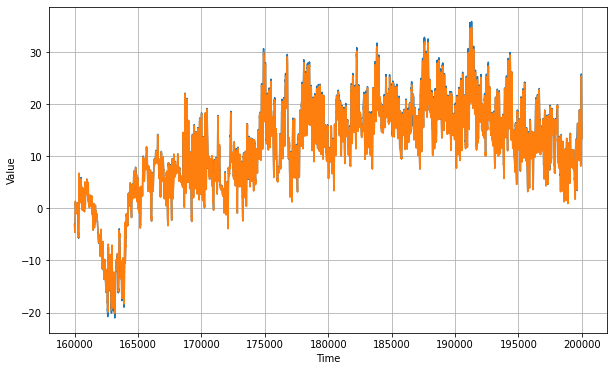

In [14]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

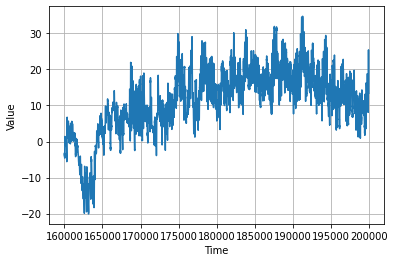

In [15]:
plot_series(time_valid, rnn_forecast)

In [16]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 0.10, mae: 0.23 for forecast
